# Testes com [Dask](https://dask.org/) em Python

Python é uma linguagem que une diferentes ferramentas para a ciência de dados, Dask é uma biblioteca em python para auxiliar a análise de grandes volumes de dados.

A programação paralela significa dividir o problema em partes separadas e unir as partes no final do processamento, Dask possui a escalabilidade existente no ecossistema python.

Os dados são divididos em chunks que podem ser manipulados indenpendentemente em paralelo.

In [93]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [94]:
def fibonacci(n):
    if n < 3:
        return 1
    else:
        return fibonacci(n - 2) + fibonacci(n - 1)

In [95]:
from dask import delayed
from time import sleep
import time
import pandas as pd

In [96]:
%%time
# Serial

x = fibonacci(10)
y = fibonacci(20)
z = fibonacci(30)
soma = sum([x, y, z])

CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 139 ms


In [97]:
%%time
soma

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 8.11 µs


838860

In [98]:
%%time
# Paralelo, construção de um gráfico

x = delayed(fibonacci)(10)
y = delayed(fibonacci)(20)
z = delayed(fibonacci)(30)
soma = delayed(sum)([x,y,z])

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 840 µs


In [99]:
%%time
# União dos dados partidos
soma.compute()

CPU times: user 23.5 ms, sys: 3.47 ms, total: 27 ms
Wall time: 163 ms


838860

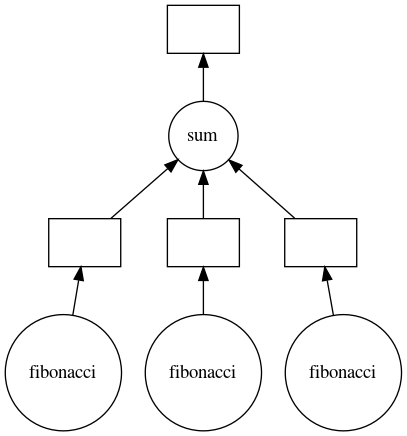

In [100]:
# Visulização dos processos partidos
soma.visualize()

## [Lei de Amdahl](https://pt.wikipedia.org/wiki/Lei_de_Amdahl)

   A lei de Amdahl, também conhecida como argumento de Amdahl, é usada para encontrar a máxima melhora esperada para um sistema em geral quando apenas uma única parte do mesmo é melhorada. Isto é frequentemente usado em computação paralela para prever o máximo speedup teórico usando múltiplos processadores.
  O speedup de um programa usando múltiplos processadores em computação paralela é limitado pelo tempo necessário para a fração sequencial de um programa. Por exemplo, se o programa precisa de 20 horas usando um único núcleo de processamento, e a parte específica de um programa que demora uma hora para executar não pode ser paralelizado, enquanto as 19 horas restantes (95%) do tempo da execução pode ser paralelizado, independente de quantos processadores são dedicados a execução paralela deste programa, o tempo de execução mínima não pode ser menor que aquela crítica uma hora. Por isso o aumento de velocidade é limitado em no máximo 20x.

In [101]:
# Criando um processo para o álculo do número de Amdahl
soma.compute()
exptimes = []

for cores in [1,2,4,8]: # Número de cores para a análise
    for trials in range(20):
        inicio = time.perf_counter()
        soma.compute(num_workers = cores)
        tempo = time.perf_counter() - inicio
        exptimes.append([cores, tempo])
        
df = pd.DataFrame(exptimes, columns = ["cores","time"])
df

,cores,time
0,1,0.164594
1,1,0.169695
2,1,0.002964
3,1,0.161441
4,1,0.170985
...,...,...
75,8,0.165403
76,8,0.159965
77,8,0.167315
78,8,0.167891


In [102]:
df.groupby('cores').describe()

time                                                              \
      count      mean       std       min       25%       50%       75%   
cores                                                                     
1      20.0  0.146656  0.062303  0.002964  0.164738  0.168623  0.172478   
2      20.0  0.154604  0.108176  0.002506  0.159258  0.166234  0.178377   
4      20.0  0.125190  0.072542  0.002573  0.118992  0.162719  0.166485   
8      20.0  0.130956  0.065773  0.002715  0.155171  0.160976  0.165638   

                 
            max  
cores            
1      0.190605  
2      0.508507  
4      0.182561  
8      0.171189

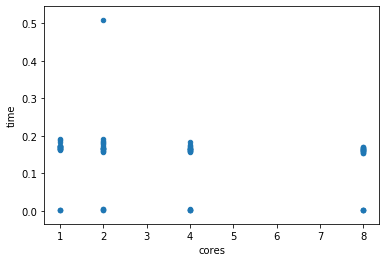

In [103]:
%matplotlib inline
df.plot(x = 'cores', y = 'time', kind = 'scatter')

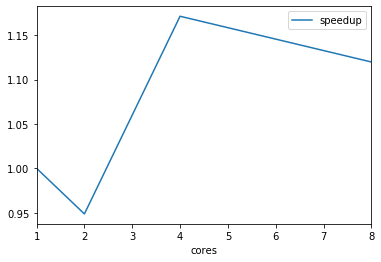

In [104]:
# Cálculo do Speedup de um processo
media = df.groupby('cores').mean()
media['speedup'] = media.loc[1].time / media['time']
media.plot(y = 'speedup', kind = 'line')

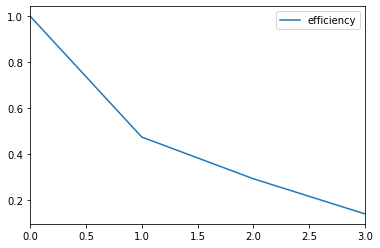

In [105]:
media.reset_index(inplace = True)
media['efficiency'] = media.loc[0].time / media['time'] / media['cores']
media.plot(y = ['efficiency'], kind = 'line');
# Essa linha é importante para a conversão em dados legíveis
df.reset_index(inplace = True)

In [106]:
media['amdahls_number'] = (media.cores/(media.cores-1)) * (1-1/media.speedup)
# Calculando o número de Amdahl
media

,cores,time,speedup,efficiency,amdahls_number
0,1,0.146656,1.000000,1.000000,NaN
1,2,0.154604,0.948591,0.474295,-0.108391
2,4,0.125190,1.171468,0.292867,0.195161
3,8,0.130956,1.119885,0.139986,0.122344


In [107]:
client.close()